# The curse: dealing with high-dimensional data [3]

In the [previous post](curse2.ipynb), I showed that a well-designed feature can help to combat the curse of dimensionality. In this third and last post, we continue with the Dot-and-Shell example and check whether machine learning without feature engineering can lead to good classifiers for the high dimensional case.

Let's load the packages we need first:

In [1]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree as BallTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
random.seed(11)

## Can the Dot-and-Shell example be handled by machine learning?

We fit a support vector machine (SVM) for classification for the 2D, 3D, 42D, and 500D case from top to bottom. We use the Gaussian kernel, which is the most popular kernel, and apply typical values for the tuning parameters. The left panels shows the first two coordinates of the data points in the calibration data set. In some sense, support vector machines work by selecting a number of points to define the decision boundary. These points, i.e. support vectors, are shown with yellow. The middle panels show the distance to the origin for calibration data, i.e. the engineered feature we used in the previous post. The support vectors are also indicated here. The right panels show the predicted class for an independent validation data set with blue/red color. Clearly, SVM works really well in all cases.

In [2]:
M = 1024

def fDataGeneration(M,N,R):
    X = np.random.normal(0,1,[M,N])
    X = np.divide(X,np.sqrt(np.sum(X**2,axis=1)[:,None]))
    xConv = False
    counter=0
    while (counter<11 and xConv==False):
        counter += 1
        U = (R**N+((R+1/2)**N-R**N)*np.random.uniform(0,1,[M,1]))**(1/float(N))
        if ~np.any(np.isnan(U.flatten())):
            xConv = True
            Y = X*U
            pass
        else:
            print(counter)
        
    return Y


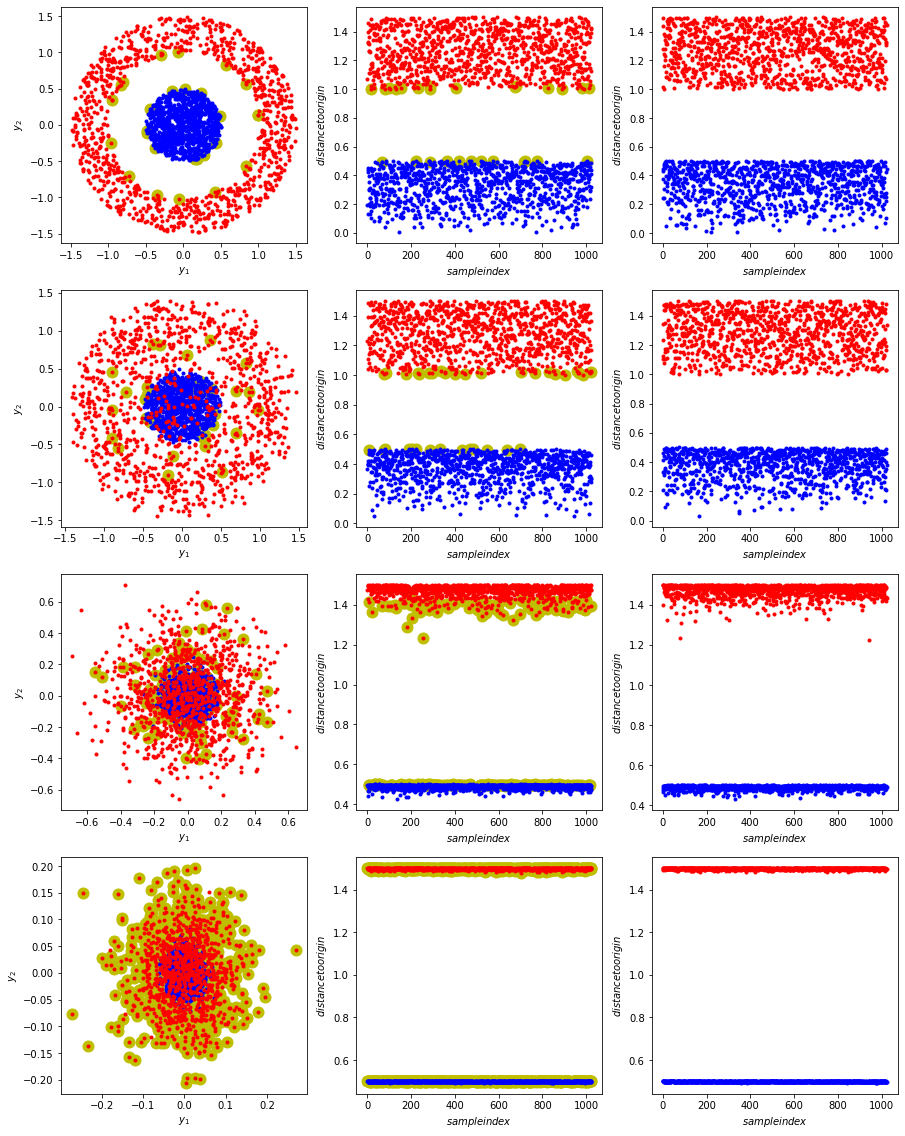

In [3]:
fig,ax = plt.subplots(nrows=4, ncols=3,figsize=[15,20])

from sklearn import svm
for row,N in enumerate([2,3,42,500]):
    Y0cal = fDataGeneration(M,N,R=0)
    Y1cal = fDataGeneration(M,N,R=1)
    Y0val = fDataGeneration(M,N,R=0)
    Y1val = fDataGeneration(M,N,R=1)
    
    Ycal = np.concatenate([Y0cal,Y1cal],axis=0)
    Yval = np.concatenate([Y0val,Y1val],axis=0)
    C0 = np.ones(M)
    C1 = -np.ones(M)
    C = np.concatenate([C0,C1],axis=0)
    
    # fit the model, don't regularize for illustration purposes
    clf = svm.SVC(kernel='rbf',gamma='scale')
    clf.fit(Ycal, C)
    
    SVindex = clf.support_
    
    x0 = np.isin(np.arange(M),SVindex)
    x1 = np.isin(np.arange(M)+M,SVindex)
    
    ax[row,0].plot(Y0cal[x0,0],Y0cal[x0,1],'yo',markersize=11)
    ax[row,0].plot(Y1cal[x1,0],Y1cal[x1,1],'yo',markersize=11)
    ax[row,0].plot(Y0cal[:,0],Y0cal[:,1],'b.')
    ax[row,0].plot(Y1cal[:,0],Y1cal[:,1],'r.')
    
    C0hat = clf.predict(Y0val)
    C1hat = clf.predict(Y1val)
    
    
    R0cal = np.linalg.norm(Y0cal,axis=1)
    R1cal = np.linalg.norm(Y1cal,axis=1)
    R0val = np.linalg.norm(Y0val,axis=1)
    R1val = np.linalg.norm(Y1val,axis=1)
    
    
    ax[row,1].plot(np.where(x0)[0],R0cal[x0],'yo',markersize=11)
    ax[row,1].plot(np.where(x1)[0],R1cal[x1],'yo',markersize=11)
    ax[row,1].plot(R0cal,'b.')
    ax[row,1].plot(R1cal,'r.')
    
    ax[row,2].plot(R0val[C0hat==+1],'b.')
    ax[row,2].plot(R1val[C1hat==-1],'r.')
    ax[row,2].plot(R0val[C0hat==-1],'r.')
    ax[row,2].plot(R1val[C1hat==+1],'b.')
    
    ax[row,0].set_xlabel('$y_1$');
    ax[row,0].set_ylabel('$y_2$');
    ax[row,1].set_xlabel('$sample index$');
    ax[row,1].set_ylabel('$distance to origin$');
    ax[row,2].set_xlabel('$sample index$');
    ax[row,2].set_ylabel('$distance to origin$');
    

## Performance of SVM

We now build SVM classifiers for $N$ running from 2 to 500. The next figure shows the results. The classification performances (top panel) are excellent: the SVM classifiers deliver perfect classification regardless of the dimension. The number of support vectors required to describe the decision boundary increases however with the number of dimensions (bottom panel).

Clearly, the Dot-and-Shell example can be handled fairly well with a support vector machine (SVM) classification model, despite the high-dimensional nature and despite the fact that the data of one class lives in a high-dimensional space. 

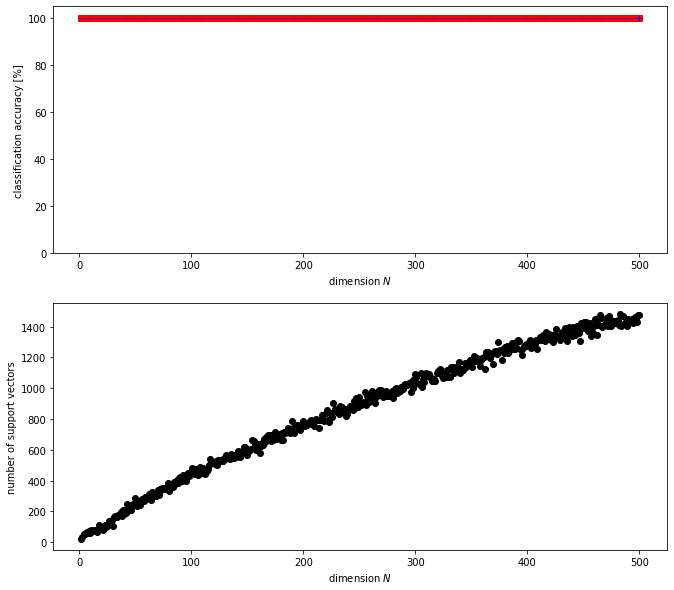

In [4]:
#%matplotlib notebook
Nmax=500

fig,ax = plt.subplots(nrows=2, ncols=1,figsize=[11,10])

C0 = np.ones(M)
C1 = -np.ones(M)
C = np.concatenate([C0,C1],axis=0)
    
for N in np.arange(2,Nmax+1):
    
    Y0cal = fDataGeneration(M,N,R=0)
    Y1cal = fDataGeneration(M,N,R=1)
    Y0val = fDataGeneration(M,N,R=0)
    Y1val = fDataGeneration(M,N,R=1)
    
    Ycal = np.concatenate([Y0cal,Y1cal],axis=0)
    Yval = np.concatenate([Y0val,Y1val],axis=0)
    
    # fit the model, don't regularize for illustration purposes
    clf = svm.SVC(kernel='rbf',gamma='scale')
    clf.fit(Ycal, C)
    
    SVindex = clf.support_
    
    C0hat = clf.predict(Y0val)
    C1hat = clf.predict(Y1val)
    
    F0 = np.sum((C0hat==+1)*1.0)/M
    F1 = np.sum((C1hat==-1)*1.0)/M
    ax[0].plot(N,F1*100, 'rs')
    ax[0].plot(N,F0*100, 'b+')
    
    ax[1].plot(N,len(SVindex), 'ko')
    
ax[0].set_xlabel('dimension $N$');
ax[0].set_ylabel('classification accuracy [%]');
ax[0].set_ylim([0,105]);
ax[1].set_xlabel('dimension $N$');
ax[1].set_ylabel('number of support vectors');
 
    
plt.show()
    

## Take home message

* Separable data classes can be handled with some machine learning models, like SVMs, even if the data lives in a high-dimensional space.

* The k-nearest neigbor model and SVM models with a radial basis kernel can behave quite differently with data embedded in a high-dimensional space. This is also surprising considering that they are quite similar at a conceptual level. Their similarity is discussed frequently so I was not aware of this notable difference in performance. 
